# Data Preprocessing

首先先對新的資料做preprocessing

針對4~7月的資料匯出每個月的流量，而3月則因為欄位名稱不同，所以在另外處理，這裡就不多做贅述
```python
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

for i in range(4,8):
    v=str(i)
    data=pd.read_csv('./20170'+v+'-citibike-tripdata.csv')
    in_flow=np.zeros((3479,32,48),dtype='i')
    out_flow=np.zeros((3479,32,48),dtype='i')
    a=data.loc[:,['start station id','starttime','end station id','stoptime']]

    for i in a.itertuples():
        t=time.strptime(str(i[2]),"%Y-%m-%d %H:%M:%S")
        j=int(i[1])
        k=int(t.tm_mday)
        l=int(t.tm_hour*2+t.tm_min/30)
        out_flow[j][k][l]=out_flow[j][k][l]+1
        t=time.strptime(str(i[4]),"%Y-%m-%d %H:%M:%S")
        j=int(i[3])
        k=int(t.tm_mday)
        l=int(t.tm_hour*2+t.tm_min/30)
        in_flow[j][k][l]=in_flow[j][k][l]+1

    with open('0'+v+'_inout_flow_data.csv','w') as x:
        o=csv.writer(x)
        o.writerow(['station_id','time','in_flow_count','out_flow_count'])
        for i in range(1,3479):
            for j in range(1,32):
                for k in range(48):
                    o.writerow([i,(j-1)*48+k,in_flow[i][j][k],out_flow[i][j][k]])
```

再來將3~7月有紀錄的車站資料撈出來，同樣對3月做了個別處理
```python
import pandas as pd

l=[]
for i in range(4,8):
	v=str(i)
	print(v)
	data=pd.read_csv('20170'+v+'-citibike-tripdata.csv')
	a=data.loc[:,['end station id','end station name','end station latitude','end station longitude']]
	b=data.loc[:,['start station id','start station name','start station latitude','start station longitude']]
	b.columns=['end station id','end station name','end station latitude','end station longitude']
	a=a.append(b).drop_duplicates('end station id')
	l.append(a)

data=pd.read_csv('201703-citibike-tripdata.csv')
a=data.loc[:,['End Station ID','End Station Name','End Station Latitude','End Station Longitude']]
b=data.loc[:,['Start Station ID','Start Station Name','Start Station Latitude','Start Station Longitude']]
b.columns=['End Station ID','End Station Name','End Station Latitude','End Station Longitude']
out=a.append(b).drop_duplicates('End Station ID')
out.columns=['end station id','end station name','end station latitude','end station longitude']

for i in range(0,len(l)):
	out=out.append(l[i]).drop_duplicates('end station id')

out=out.drop_duplicates('end station id').sort_values('end station id')
out.to_csv('station_data.csv',index=False)
```

接著將題目要用到的flow_count合併起來，並且只擷取車站編號519來進行分析，這邊我將3~6月的資料當作training data，而7月當作testing data
```python
import pandas as pd

data=pd.DataFrame()
for i in range(3,7):
	v=str(i)
	a=pd.read_csv('0'+v+'_inout_flow_data.csv')
	a=a.loc[a['station_id']==519,:]
	data=pd.concat([data,a])
data.to_csv('train_data.csv',index=False)
```

# A1

首先先將繪圖與抽取資料的function定義好

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [10]:
def extract(data,x,y):
    Max=len(data)-48*14
    for i in range(0,Max,48):#for everyday as the first day
        for j in range(48):#to extract every period of a day
            d=[]
            for k in range(14):#for the 14 days of a set of data
                d.append(data[i+j+48*k])
            x[j].append(d)
            y[j].append(data[i+j+48*14])

抽取資料時間的部份，第一層迴圈為可以當作接下來14天中第1天的index值，第二層是根據不同時段分別extra出來，第3層就是在這14天同時段的部份append成一個list，最後在append到該時段的大list，而y則是已此14天為基準的第15天的流量

In [11]:
def plot(y_t,y_pred):
    t=[]
    pred=[]
    for i in range(len(y_t[0])):
        for j in range(len(y)):
            t.append(y_t[j][i])
            pred.append(y_pred[j][i])
    plt.figure(figsize=(15,13))
    plt.xlabel('time')
    plt.ylabel('out_flow_count')
    plt.scatter(np.arange(len(t)),t,s=13,c='red',label='original')
    plt.scatter(np.arange(len(pred)),pred,s=13,c='white',label='predict')
    plt.legend()
    plt.show()

繪圖部份則是畫出真實的y值與預測的y值，方便比較

這裡我用的是分佈圖，真實結果用紅色表示，預測結果用白色，且兩種的大小相等，如此若這個model的結果夠好的話，畫面上應該要是全白（真實值完全被預測值覆蓋住），而紅色愈多的話代表這個model愈不準

## Data prepare

這邊我選擇將out_flow_count每5做一個discretization

In [90]:
disc=10
data=pd.read_csv('07_inout_flow_data.csv')
x=pd.read_csv('train_data.csv').loc[:,'out_flow_count']
x_t=data.loc[data['station_id']==519,'out_flow_count']
X=(np.array(x)/disc).astype(int).tolist()
X_t=(np.array(x_t)/disc).astype(int).tolist()

x=[]
y=[]
x_t=[]
y_t=[]
y_pred=[]
for i in range(48): #initialize
    x.append([])
    y.append([])
    x_t.append([])
    y_t.append([])
    y_pred.append([])
extract(X,x,y)
extract(X_t,x_t,y_t)

## K-Nearest-Neighbor

首先先利用elbow-method，找出分數最高的k值

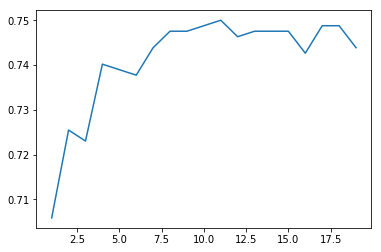

In [91]:
def K_Near(x,y,x_t,y_t,y_pred,n):
	score=0
	t=0
	for i in range(48):
		classifier=KNeighborsClassifier(n_neighbors=n)
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
		score+=classifier.score(x_t[i],y_t[i])
		t+=1
	return score/t

a=[]
for i in range(1,20):
	a.append(K_Near(x,y,x_t,y_t,y_pred,i))
plt.plot(np.linspace(1,19,19),a)
plt.show()

由上圖可以看到K=11時，分數最高，因此K選擇11

0.75
K-Near cost 0.09511 s.


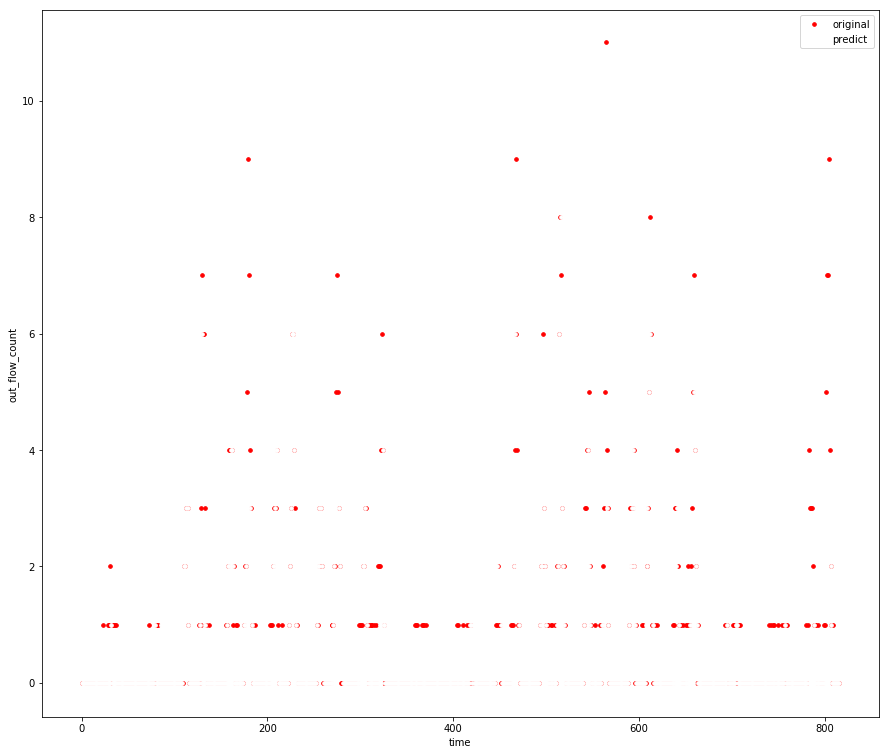

In [106]:
tstart=time.time()
print(K_Near(x,y,x_t,y_t,y_pred,11))
print('K-Near cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)


## Naive Bayes

這裡我假定車流量是常態分佈，用GaussianNB來去預測

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:432: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:434: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


0.638480392157
It cost 0.29114 s.


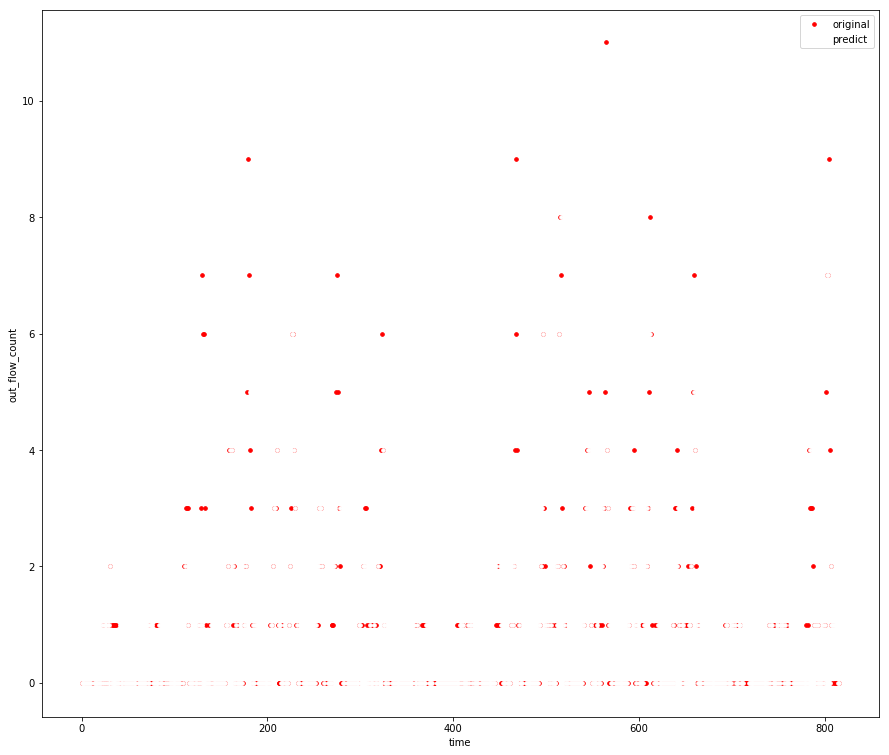

In [93]:
from sklearn.naive_bayes import GaussianNB

def Gaussian_NB(x,y,x_t,y_t,y_pred):
	score=0
	t=0
	for i in range(48):
		classifier=GaussianNB()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
		score+=classifier.score(x_t[i],y_t[i])
		t+=1
	return score/t

tstart=time.time()
print(Gaussian_NB(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')

plot(y_t,y_pred)

比K-Nearst-neighbor還要慢，而且結果也比較差，而且還因為算式裡出現0而warning

## RandomForest

這邊我用RandomForestRegressor來試試看

In [94]:
from sklearn.ensemble import RandomForestClassifier

def RandomForest(x,y,x_t,y_t,y_pred):
	score=0
	t=0
	for i in range(48):
		classifier=RandomForestClassifier()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
		score+=classifier.score(x_t[i],y_t[i])
		t+=1
	return score/t

0.735294117647
It cost 0.61492 s.


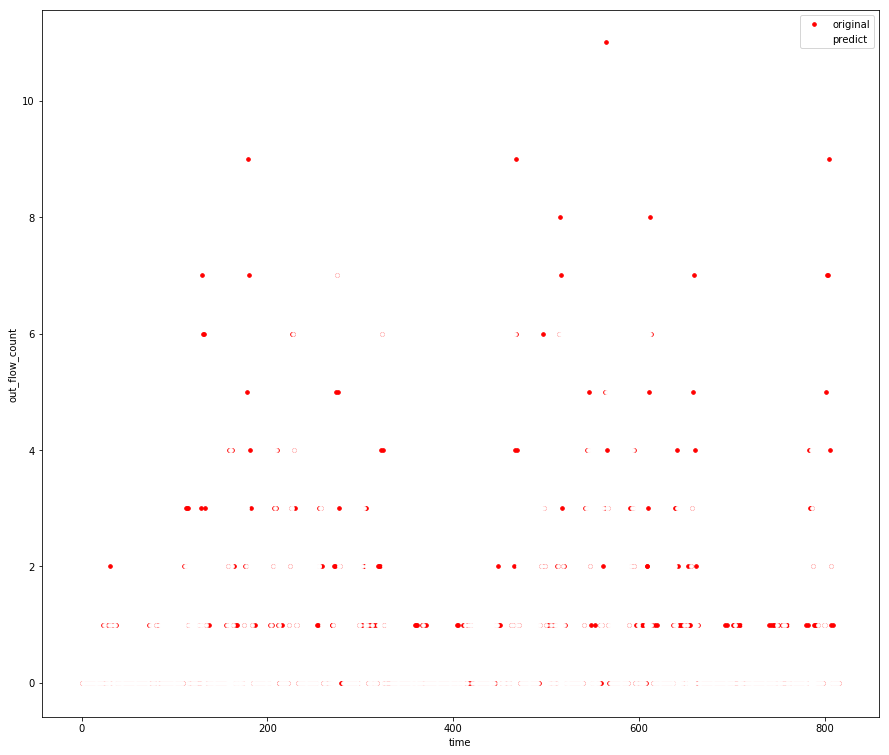

In [107]:
tstart=time.time()
print(RandomForest(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')

plot(y_t,y_pred)

結果還不錯，但時間也花的較久，而且每次執行結果都有些微差別，不過影響程度不大

## SVC

error in 0
error in 1
error in 2
error in 3
error in 4
error in 5
error in 6
error in 7
error in 8
error in 9
error in 10
error in 46
error in 47
0.650420168067
It cost 0.30888 s.


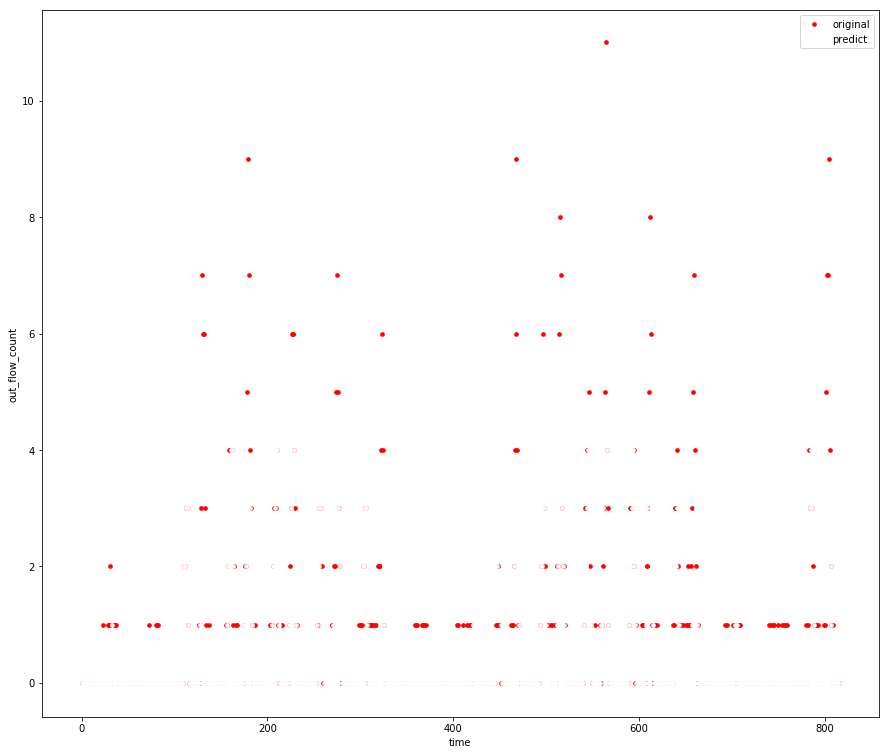

In [96]:
from sklearn.svm import SVC
def svc(x,y,x_t,y_t,y_pred):
	score=0
	t=0
	for i in range(48):
		classifier=SVC()
		try:
			classifier.fit(np.array(x[i]),np.array(y[i]))
			y_pred[i]=classifier.predict(x_t[i])
			score+=classifier.score(x_t[i],y_t[i])
			t+=1
		except:
			print('error in '+str(i))
			y_pred[i]=np.zeros(17)
			continue
	return score/t

tstart=time.time()
print(svc(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')

plot(y_t,y_pred)

結果不是很優秀，count較大的點都預測不太到，且count=1預測的十分差

而因為SVC不能處理只有同一種值的情況（這裡是一個時段內全都是0的情況），因此特別except出來全歸零

## Other - - PassiveAggressiveClassifier

這裡我選擇用一種linear model，PassiveAggressiveClassifier來做做看

passive，如果目前的方法是正確的，就繼續保留住這個model。

Aggressive，如果目前的方法有誤，就修改目前規則，並調整分類錯誤的例子

error in 0
error in 1
error in 2
error in 3
error in 4
error in 5
error in 6
error in 7
error in 8
error in 9
error in 10
error in 46
error in 47
0.566386554622
It cost 0.47345 s.


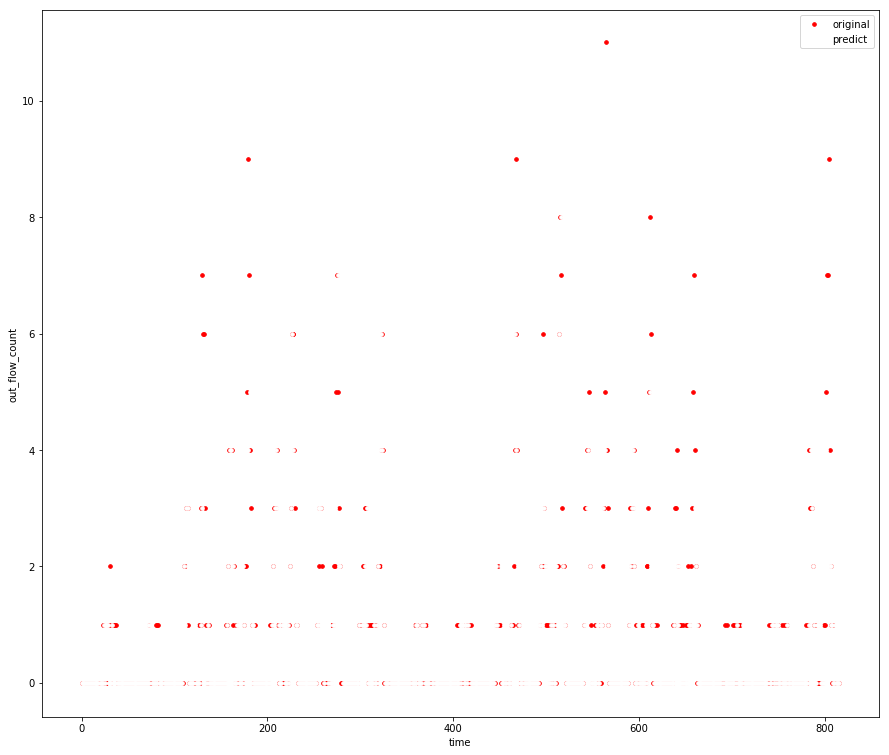

In [97]:
from sklearn.linear_model import PassiveAggressiveClassifier

def pac(x,y,x_t,y_t,y_pred):
	score=0
	t=0
	for i in range(48):
		classifier=PassiveAggressiveClassifier(max_iter=len(x[i]))
		try:
			classifier.fit(np.array(x[i]),np.array(y[i]))
			y_pred[i]=classifier.predict(x_t[i])
			score+=classifier.score(x_t[i],y_t[i])
			t+=1
		except:
			print('error in '+str(i))
			y_pred[i]=np.zeros(17)
			continue
	return score/t

tstart=time.time()
print(pac(x,y,x_t,y_t,y_pred))

print('It cost '+str(round(time.time()-tstart,5))+' s.')

plot(y_t,y_pred)

結果滿糟糕的，雖然看起來紅色的部份很少，但很多都是因為隔壁的點預測錯誤而蓋住的

## 總比較

| Method | running time | score |
| --- | --- | --- |
| K-Nearest-Neighbor | 0.0951 | 0.7500 |
| Naive Bayes | 0.2911 | 0.6384 |
| Random Forest | 0.6149 | 0.7353 |
| SVC | 0.3089 | 0.6504 |
| PA | 0.4735 | 0.5664 |

以score和running time來看，K-Nearest-Neighbor應該是最好的一個，執行時間較低，又可以有不錯的成績，而第二好大概是Random Forest，分數也相當高，但速度卻是花最久時間的。

但也有可能是剛好這兩種方法比較適合用於目前的資料，又或者是其中的參數還可以再做調整來增進預測的效果，原因可能要深度了解這些演算法是怎麼實作之後才能得知了

# A2

由於第一個時段（index=0）到第十一個時段（index=10）的流量都是0，所以這邊我改用第十二個時段（index=11）時來做

In [114]:
def print_confusion(y_t,y_pred):
	y=np.array(y_t)
	p=np.array(y_pred)
	count=len(y)
	total=y.max()
	total=np.maximum(total,p.max())
	print("Original:",end='')
	print(list(y_t))
	print("Predict :",end='')
	print(list(y_pred))
	print(end='\t')
	for i in range(total+1):
		print(i,end='\t\t')
	print()
	for i in range(total+1):
		print(i,end='\t')
		for j in range(total+1):
			c=0
			for k in range(len(y)):
				if(y[k]==i and p[k]==j):
					c+=1
			print(str(c)+'/'+str(count)+'('+str(round(c/count,3))+')',end='\t')
		print()

classifier=GaussianNB()
classifier.fit(x[11],y[11])
y_pred[11]=classifier.predict(x_t[11])
print_confusion(y_t[11],y_pred[11])

Original:[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predict :[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	0		1		
0	11/17(0.647)	3/17(0.176)	
1	1/17(0.059)	2/17(0.118)	


第一行與第二行分別是真實資料與預測資料，用來方便觀察

接著是confusion matrix，縱軸是真實流量，橫軸是預測流量，分母是總個數，分子是該情況個數，後面括號為比例

# A3

比較可以調整的參數大概就是C(Penalty parameter of the error term)

因此我針對不同的C得到不同的score，並將圖畫出來比較

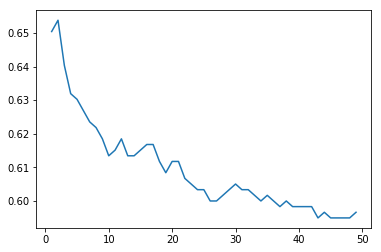

In [99]:
def svc(x,y,x_t,y_t,y_pred,c):
	score=0
	t=0
	for i in range(48):
		classifier=SVC(C=c)
		try:
			classifier.fit(np.array(x[i]),np.array(y[i]))
			y_pred[i]=classifier.predict(x_t[i])
			score+=classifier.score(x_t[i],y_t[i])
			t+=1
		except:
			y_pred[i]=np.zeros(17)
			continue
	return score/t

a=[]
for i in range(1,50):
	a.append(svc(x,y,x_t,y_t,y_pred,i))
plt.plot(np.linspace(1,49,49),a)
plt.show()

可以看到C=1時，score會最高，C愈大，score愈小。

而C=1就是SVC預設的參數，跟先前沒有調整的一樣，所以就不再多做了

# B

因為要直接用原始資料，所以要重新準備data

且因為沒有要discretization count值，所以將plot改成繪製折線圖

In [20]:
from sklearn.metrics import mean_squared_error

data=pd.read_csv('07_inout_flow_data.csv')
x=pd.read_csv('train_data.csv').loc[:,'out_flow_count']
x_t=data.loc[data['station_id']==519,'out_flow_count']
X=np.array(x).astype(int).tolist()
X_t=np.array(x_t).astype(int).tolist()

x=[]
y=[]
x_t=[]
y_t=[]
y_pred=[]
for i in range(48): #initialize
	x.append([])
	y.append([])
	x_t.append([])
	y_t.append([])
	y_pred.append([])
extract(X,x,y)
extract(X_t,x_t,y_t)

def plot(y_t,y_pred):
    t=[]
    pred=[]
    for i in range(len(y_t[0])):
        for j in range(len(y)):
            t.append(y_t[j][i])
            pred.append(y_pred[j][i])
    plt.figure(figsize=(15,13))
    plt.xlabel('time')
    plt.ylabel('out_flow_count')
    plt.plot(np.arange(len(t)),t,label='original')
    plt.plot(np.arange(len(pred)),pred,label='predict')
    plt.legend()
    plt.show()

## ARIMA

首先要做的就跟所有都很不一樣，因此要特別處理資料

test_data.scv與train_data_2.csv一樣是取7月和3~6月519號車站的資料，不一樣的點在多增加了星期與月份(這邊尚未用到)

再來就是利用ARIMA進行回歸分析，這裡因為對於參數與方法都非常不熟悉，因此只能取網路上別人取的數值試試看

77.1567554637
It cost 374.04095 s.


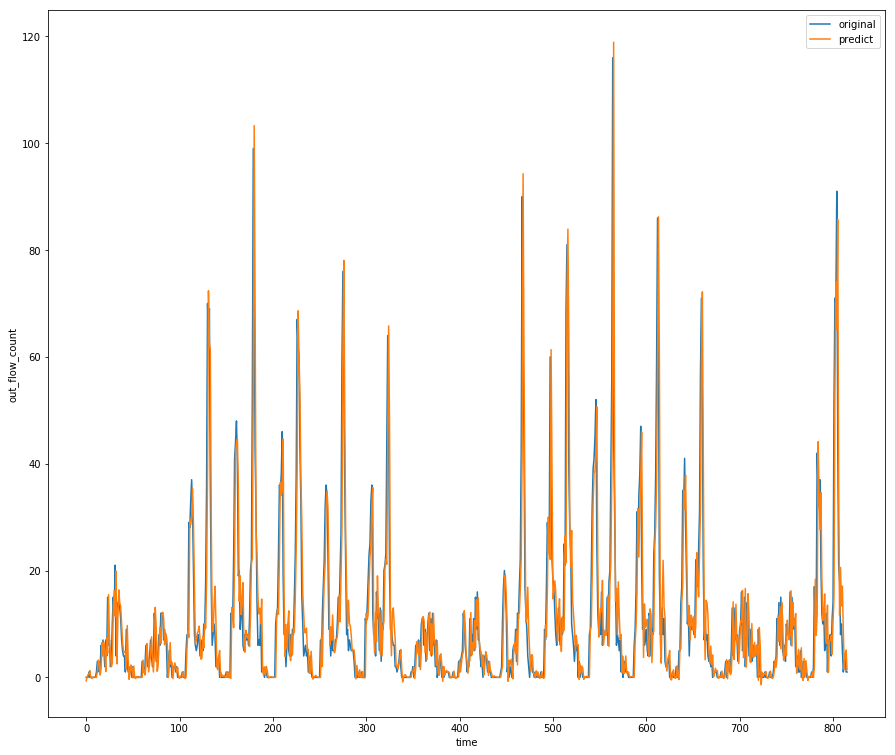

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

x_t=pd.read_csv('test_data.csv').loc[:,['out_flow_count']]
x=pd.read_csv('train_data_2.csv').loc[:,['out_flow_count']]
x_t[['out_flow_count']]=x_t[['out_flow_count']].astype(float)
x[['out_flow_count']]=x[['out_flow_count']].astype(float)
train=x.values
test=x_t.values
history=[x for x in train]
for i in range(672):
    history.append(test[i])
test=test[672:]
prediction=list()
tstart=time.time()
for t in range(len(test)):
    model=ARIMA(history,order=(5,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    prediction.append(yhat)
    history.append(test[t])
print(mean_squared_error(test,prediction))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plt.figure(figsize=(15,13))
plt.xlabel('time')
plt.ylabel('out_flow_count')
plt.plot(test,label='original')
plt.plot(prediction,label='predict')
plt.legend()
plt.show()

結果雖然看起來不太好，但畫出來的圖卻十分令人驚訝的準確，只是大部分的點都離真實值差了一點，累積起來的誤差才會比較大

但另一點遺憾的是時間，這樣的參數要花374秒，這超過了五分鐘的執行時間十分差勁

## Bayesian regression

47.0700999697
It cost 0.07287 s.


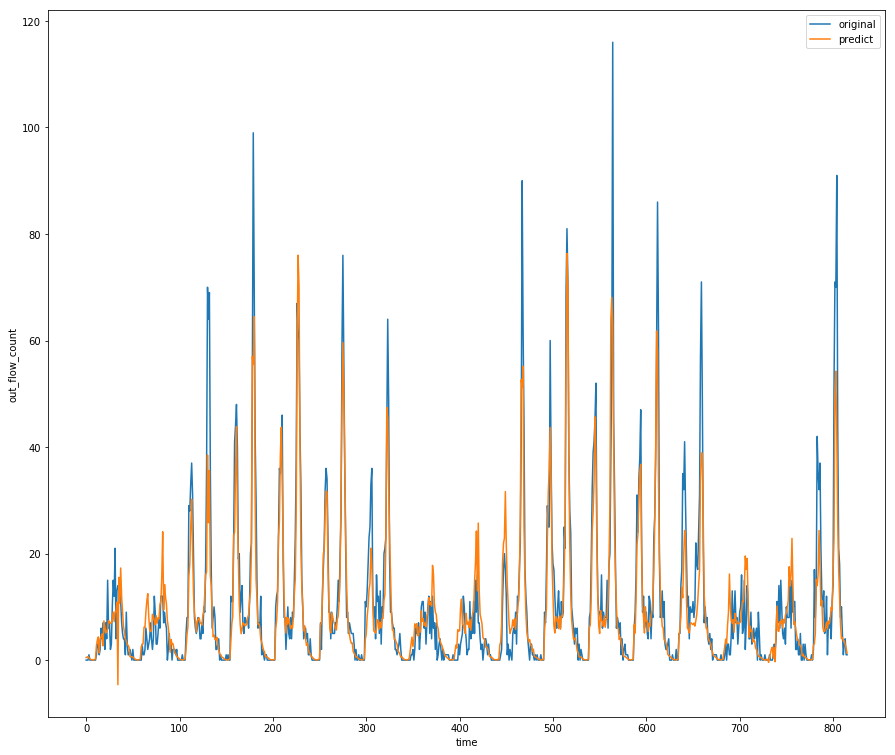

In [21]:
from sklearn.linear_model import BayesianRidge

def bayesian(x,y,x_t,y_t,y_pred):
	for i in range(48):
		classifier=BayesianRidge()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
	return mean_squared_error(y_t,y_pred)

tstart=time.time()
print(bayesian(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

結果相當不錯，畫出來的圖可以大略勾勒原始圖的趨勢，但如果要用在準確估計該點值時可能效果就不太好了

## Decision tree regression

75.4458894632
It cost 0.05154 s.


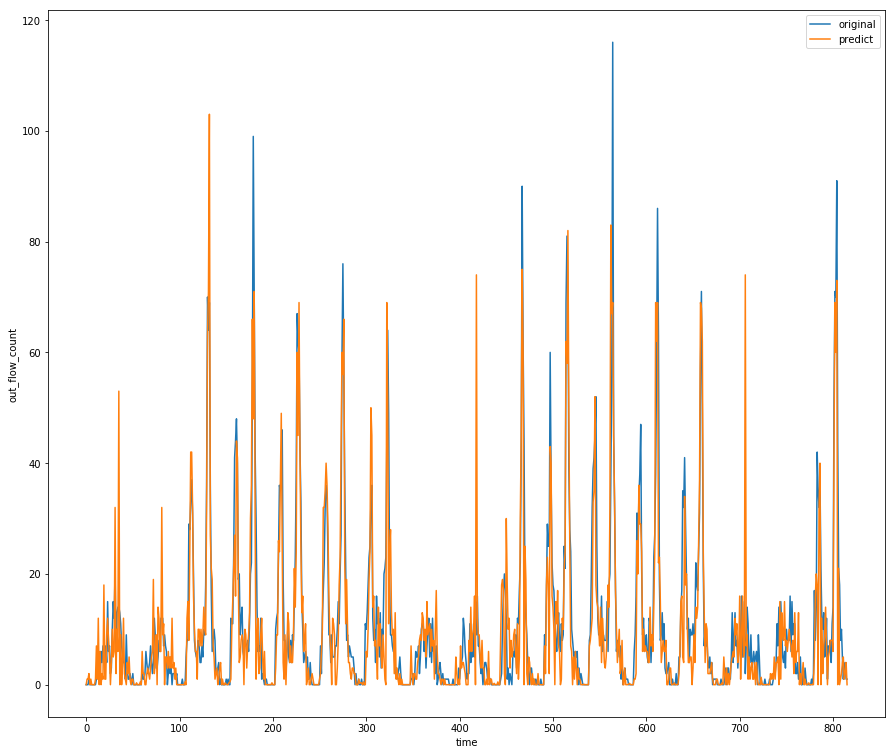

In [22]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree(x,y,x_t,y_t,y_pred):
	for i in range(48):
		classifier=DecisionTreeRegressor()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
	return mean_squared_error(y_t,y_pred)

tstart=time.time()
print(decision_tree(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

結果不太優秀，雖然誤差比用ARIMA小，但畫出來的圖卻雜亂許多

## SVR

105.663418756
It cost 0.08992 s.


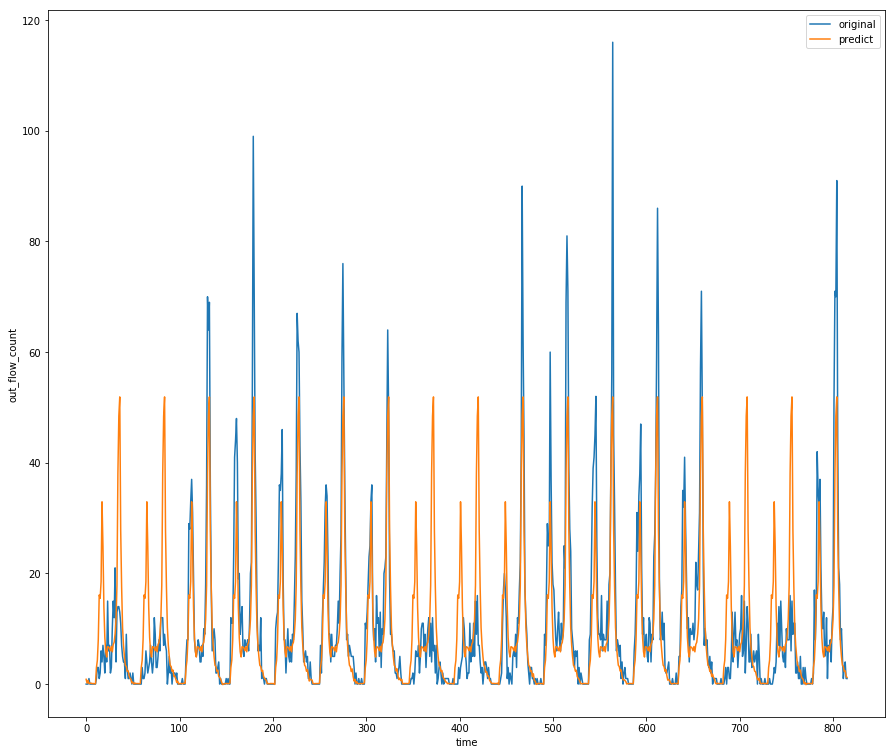

In [23]:
from sklearn.svm import SVR

def svr(x,y,x_t,y_t,y_pred):
	for i in range(48):
		classifier=SVR()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
	return mean_squared_error(y_t,y_pred)

tstart=time.time()
print(svr(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

結果十分糟糕，既沒有勾勒出趨勢，也沒有預測到真實值，因此誤差十分大

## Other - - GradientBoostingRegressor

43.4524231739
It cost 1.57443 s.


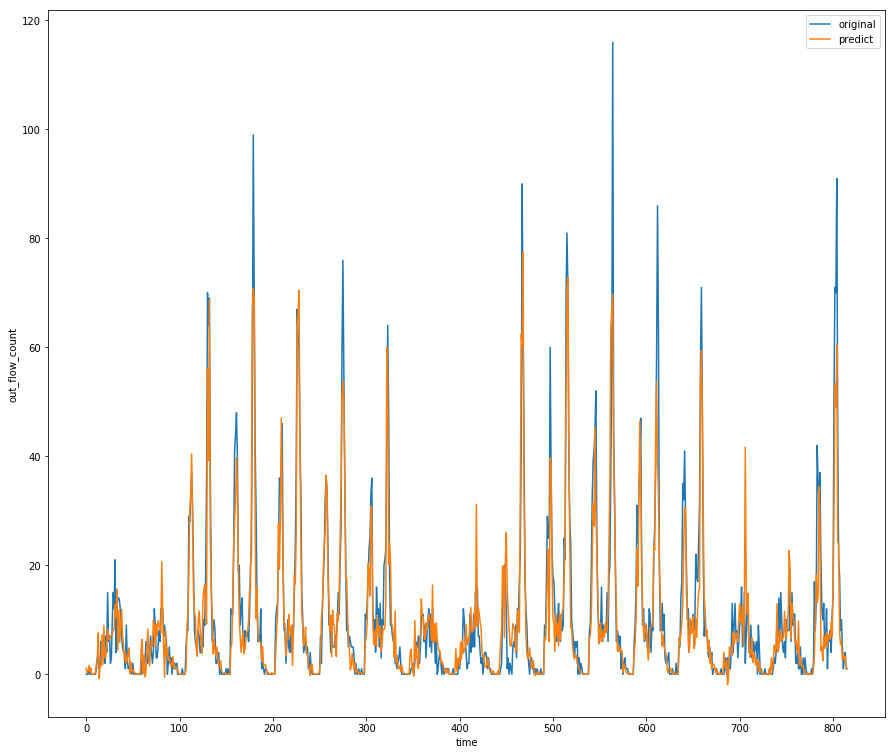

In [125]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient(x,y,x_t,y_t,y_pred):
	for i in range(48):
		classifier=GradientBoostingRegressor()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
	return mean_squared_error(y_t,y_pred)

tstart=time.time()
print(gradient(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

意外的找到了這個model，讓誤差成為這些regression中最小的

## 總比較

| Method | running time | mean squared error |
| --- | --- | --- |
| ARIMA | 374.0410 | 77.1568 |
| Bayesian regression | 0.0729 | 47.0701 |
| Decision tree regression | 0.0515 | 75.4459 |
| SVR | 0.0899 | 105.6634 |
| Gradient Boosting Regressor | 1.5744 | 43.4524 |

已誤差來看的話Gradient Boosting Regressor是表現最好的，雖然花了較久的時間，但能達成這樣的成效也是頗為值得

而我個人最喜歡的還是ARIMA，他預測的準確度真的令人十分驚豔，就只是無奈花了非常久的時間來執行

# C

我想試著改進Regression中，表現最好的Gradient Boosting Regressor

首先先考慮了星期，將星期1~7乘以100加上原本的流量試試看

42.9374400108
It cost 1.17635 s.


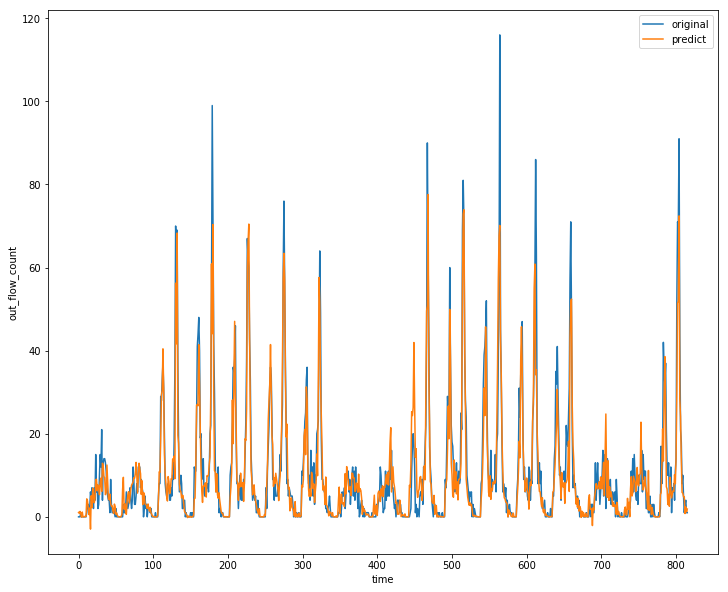

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def extract(data,x,y):
	Max=len(data)-48*14
	for i in range(0,Max,48): #for everyday as the first day
		for j in range(48):	#to extract every period of a day
			d=[]
			for k in range(14): #for the 14 days of a set of data
				d.append(data[i+j+48*k][1]*100+data[i+j+48*k][0])
			x[j].append(d)
			y[j].append(data[i+j+48*14][1])

def plot(y_t,y_pred):
    t=[]
    pred=[]
    for i in range(len(y_t[0])):
        for j in range(len(y)):
            t.append(y_t[j][i])
            pred.append(y_pred[j][i])
    plt.figure(figsize=(12,10))
    plt.xlabel('time')
    plt.ylabel('out_flow_count')
    plt.plot(np.arange(len(t)),t,label='original')
    plt.plot(np.arange(len(pred)),pred,label='predict')
    plt.legend()
    plt.show()

def gradient(x,y,x_t,y_t,y_pred):
	for i in range(48):
		classifier=GradientBoostingRegressor()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
	return mean_squared_error(y_t,y_pred)

data=pd.read_csv('test_data.csv')
x=pd.read_csv('train_data_2.csv').loc[:,['day','out_flow_count']]
x_t=data.loc[:,['day','out_flow_count']]
X=(np.array(x)).astype(int).tolist()
X_t=(np.array(x_t)).astype(int).tolist()

x=[]
y=[]
x_t=[]
y_t=[]
y_pred=[]
for i in range(48): #initialize
	x.append([])
	y.append([])
	x_t.append([])
	y_t.append([])
	y_pred.append([])
extract(X,x,y)
extract(X_t,x_t,y_t)
tstart=time.time()

print(gradient(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

結果似乎沒有進步太多，那如果是classification的呢？

這邊選用當時表現最好的K-Nearest-Neighbor進行

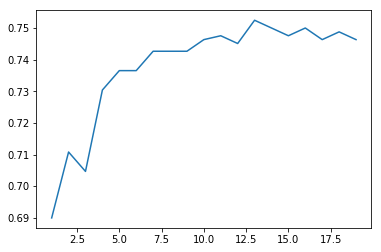

In [14]:
from sklearn.neighbors import KNeighborsClassifier

def plot(y_t,y_pred):
    t=[]
    pred=[]
    for i in range(len(y_t[0])):
        for j in range(len(y)):
            t.append(y_t[j][i])
            pred.append(y_pred[j][i])
    plt.figure(figsize=(15,13))
    plt.xlabel('time')
    plt.ylabel('out_flow_count')
    plt.scatter(np.arange(len(t)),t,s=13,c='red',label='original')
    plt.scatter(np.arange(len(pred)),pred,s=13,c='white',label='predict')
    plt.legend()
    plt.show()

def K_Near(x,y,x_t,y_t,y_pred,n):
	score=0
	t=0
	for i in range(48):
		classifier=KNeighborsClassifier(n_neighbors=n)
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
		score+=classifier.score(x_t[i],y_t[i])
		t+=1
	return score/t

disc=10
data=pd.read_csv('test_data.csv')
x=pd.read_csv('train_data_2.csv').loc[:,['day','out_flow_count']]
x_t=data.loc[:,['day','out_flow_count']]
X=np.array(x)
X_t=np.array(x_t)
X[:,1]=X[:,1]/disc
X_t[:,1]=X_t[:,1]/disc

x=[]
y=[]
x_t=[]
y_t=[]
y_pred=[]
for i in range(48): #initialize
	x.append([])
	y.append([])
	x_t.append([])
	y_t.append([])
	y_pred.append([])
extract(X,x,y)
extract(X_t,x_t,y_t)

a=[]
for i in range(1,20):
	a.append(K_Near(x,y,x_t,y_t,y_pred,i))
plt.plot(np.linspace(1,19,19),a)
plt.show()

0.75
It cost 0.09014 s.


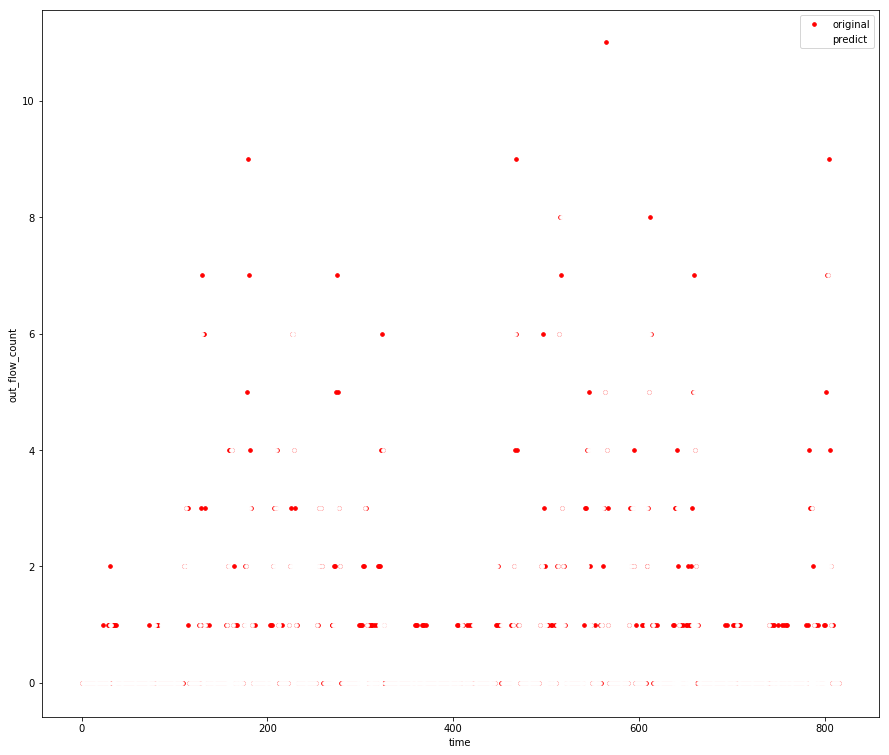

In [20]:
tstart=time.time()
print(K_Near(x,y,x_t,y_t,y_pred,14))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

可以發現即使是在最高點，分數依然是0.75，雖然時間略為下降了一點

那試試看classification中第二好的Random Forest呢？

0.723039215686
It cost 0.60034 s.


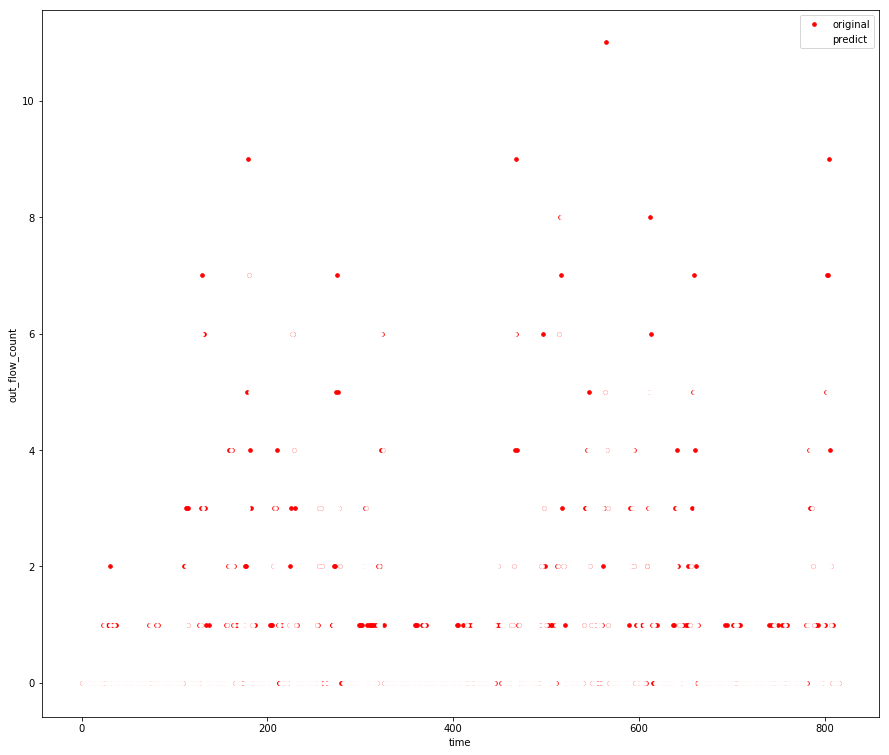

In [15]:
from sklearn.ensemble import RandomForestClassifier
def RandomForest(x,y,x_t,y_t,y_pred):
	score=0
	t=0
	for i in range(48):
		classifier=RandomForestClassifier()
		classifier.fit(x[i],y[i])
		y_pred[i]=classifier.predict(x_t[i])
		score+=classifier.score(x_t[i],y_t[i])
		t+=1
	return score/t

tstart=time.time()
print(RandomForest(x,y,x_t,y_t,y_pred))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plot(y_t,y_pred)

結果出來比原本的糟了一些，但時間也跟K-Nearest-Neighbor一樣下降了

也許這代表，當我們用這樣同一時段去預測同一時段的方式時，星期的影響反而沒有那麼大，而增加了測資的範圍之後，在做classification時，因為X的值域增大的，training data相對來說變小，所以成效反而有機會跟著降低

最後我想試試看ARIMA用其他參數去帶，看看時間和誤差會怎樣變化

75.6023691301
It cost 2769.17655 s.


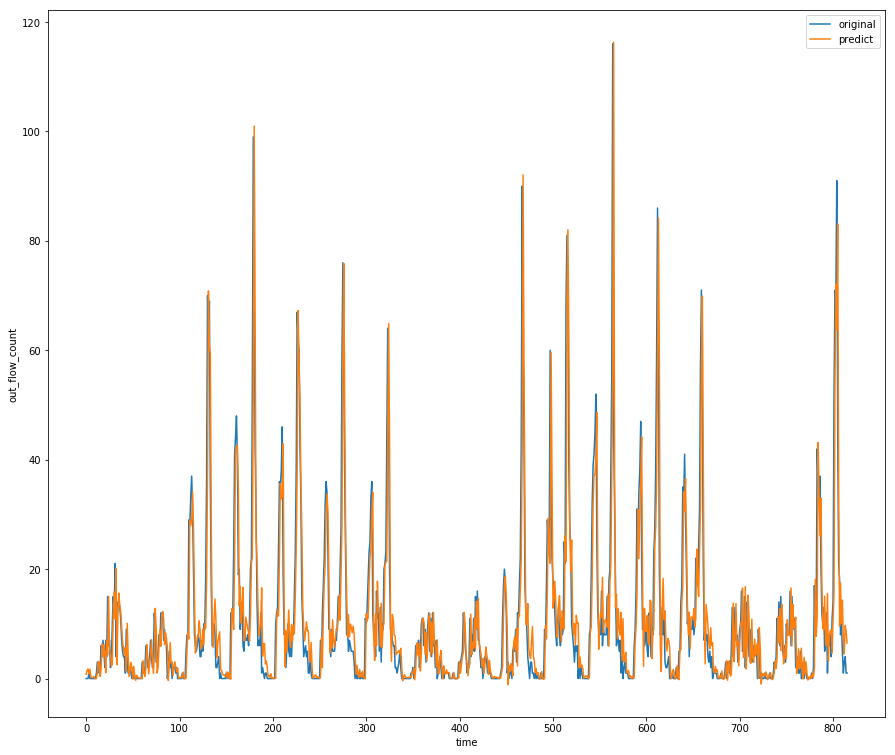

In [13]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

x_t=pd.read_csv('test_data.csv').loc[:,['out_flow_count']]
x=pd.read_csv('train_data_2.csv').loc[:,['out_flow_count']]
x_t[['out_flow_count']]=x_t[['out_flow_count']].astype(float)
x[['out_flow_count']]=x[['out_flow_count']].astype(float)
train=x.values
test=x_t.values
history=[x for x in train]
for i in range(672):
    history.append(test[i])
test=test[672:]
prediction=list()
tstart=time.time()
for t in range(len(test)):
    model=ARIMA(history,order=(10,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    prediction.append(yhat)
    history.append(test[t])
print(mean_squared_error(test,prediction))
print('It cost '+str(round(time.time()-tstart,5))+' s.')
plt.figure(figsize=(15,13))
plt.xlabel('time')
plt.ylabel('out_flow_count')
plt.plot(test,label='original')
plt.plot(prediction,label='predict')
plt.legend()
plt.show()

將第一個參數略微調高到10，成功降低了一段誤差，但時間也大幅的上升了，或許再調更高可以讓誤差更低，但時間依然是個令人頭痛的問題